In [1]:
# ==============================
# IMPORTS
# ==============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

In [2]:
# ==============================
# CONFIG
# ==============================
DATA_DIR = r"D:\Projects\CLARITY\Model\Dataset"
IMG_ROOT = os.path.join(DATA_DIR, "archive")  # all subfolders with images
CSV_PATH = os.path.join(DATA_DIR, "archive", "Data_Entry_2017.csv")  # adjust file name
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)

Using device: cuda


In [3]:
# ==============================
# LOAD CSV
# ==============================
df = pd.read_csv(CSV_PATH)
print(df.head())

# Clean labels
df["Finding Labels"] = df["Finding Labels"].apply(lambda x: x.replace(" ", ""))

# Extract unique diseases
all_labels = set()
for labels in df["Finding Labels"]:
    for l in labels.split("|"):
        all_labels.add(l)

all_labels = sorted(list(all_labels))
print("Unique diseases:", all_labels)
print("Total classes:", len(all_labels))

# Encode labels
for label in all_labels:
    df[label] = df["Finding Labels"].apply(lambda x: 1 if label in x else 0)

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

C:\Users\Admin\AppData\Local\Temp\ipykernel_2088\297279799.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


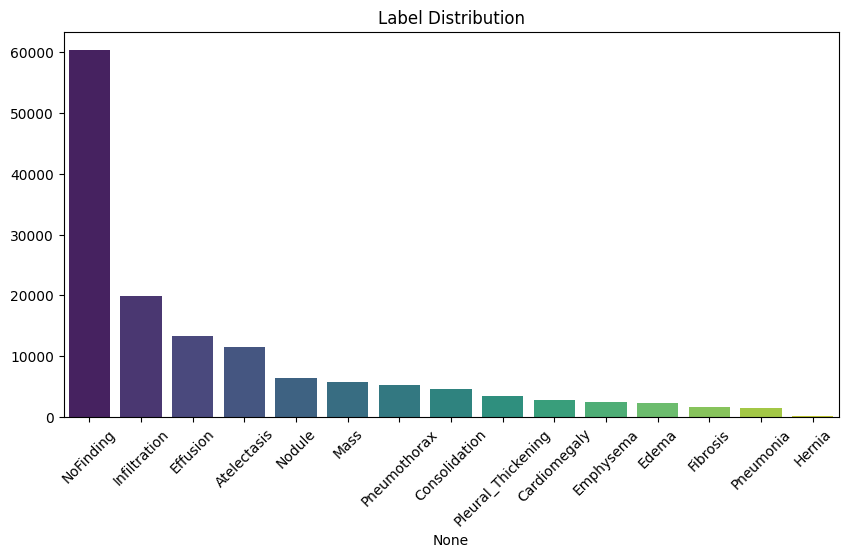

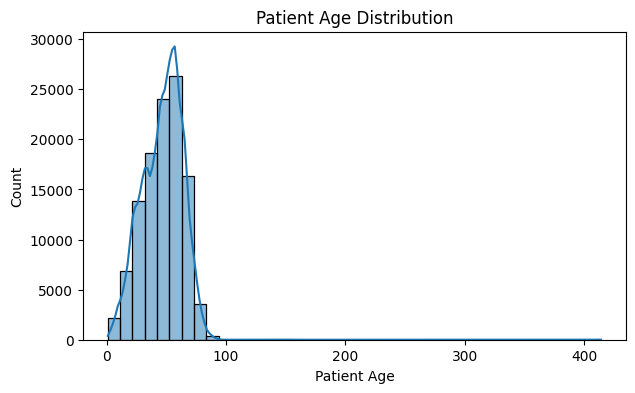

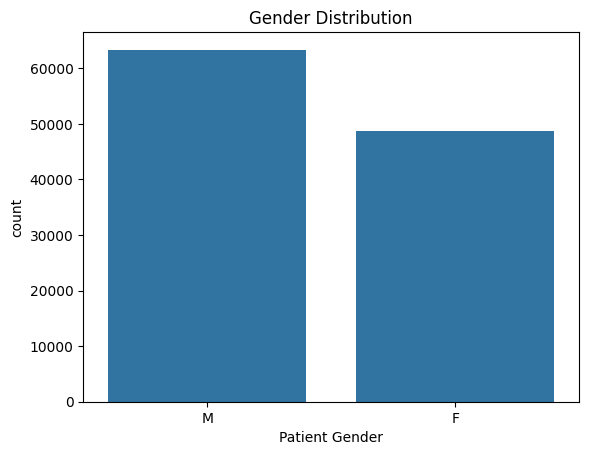

In [4]:
# ==============================
# EXPLORATORY DATA ANALYSIS
# ==============================
label_counts = df[all_labels].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Label Distribution")
plt.show()

# Age Distribution
plt.figure(figsize=(7,4))
sns.histplot(df["Patient Age"], bins=40, kde=True)
plt.title("Patient Age Distribution")
plt.show()

# Gender Count
sns.countplot(x="Patient Gender", data=df)
plt.title("Gender Distribution")
plt.show()

In [5]:
# ==============================
# DATASET CLASS
# ==============================
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, img_root, transform=None):
        self.df = dataframe
        self.img_root = img_root
        self.transform = transform
        self.labels = dataframe[all_labels].values.astype(np.float32)
        self.img_paths = dataframe["Image Index"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.img_paths[idx]
        # Search image in subfolders
        found = False
        for sub in os.listdir(self.img_root):
            img_path = os.path.join(self.img_root, sub, "images", img_name)
            if os.path.exists(img_path):
                found = True
                break
        if not found:
            raise FileNotFoundError(f"{img_name} not found in any subfolder.")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx])
        return image, label

In [6]:
# ==============================
# TRANSFORMS & DATALOADER
# ==============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_ds = ChestXRayDataset(train_df, IMG_ROOT, transform)
val_ds = ChestXRayDataset(val_df, IMG_ROOT, transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [7]:
# ==============================
# MODEL (EfficientNet-B3)
# ==============================
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, len(all_labels))
)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [8]:
# ==============================
# TRAIN LOOP
# ==============================
def train_model(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), "efficientnet_chestxray.pth")
    print("Model saved as efficientnet_chestxray.pth")

train_model(model, train_loader, val_loader, NUM_EPOCHS)

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:25<00:00,  3.18it/s]


Epoch [1/20] Train Loss: 0.1959 | Val Loss: 0.1799


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:14<00:00,  3.19it/s]


Epoch [2/20] Train Loss: 0.1790 | Val Loss: 0.1742


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:18<00:00,  3.19it/s]


Epoch [3/20] Train Loss: 0.1727 | Val Loss: 0.1738


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:13<00:00,  3.20it/s]


Epoch [4/20] Train Loss: 0.1669 | Val Loss: 0.1734


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:13<00:00,  3.20it/s]


Epoch [5/20] Train Loss: 0.1609 | Val Loss: 0.1735


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:12<00:00,  3.20it/s]


Epoch [6/20] Train Loss: 0.1540 | Val Loss: 0.1786


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:14<00:00,  3.19it/s]


Epoch [7/20] Train Loss: 0.1461 | Val Loss: 0.1823


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:12<00:00,  3.20it/s]


Epoch [8/20] Train Loss: 0.1384 | Val Loss: 0.1868


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████| 5606/5606 [29:11<00:00,  3.20it/s]


Epoch [9/20] Train Loss: 0.1303 | Val Loss: 0.1951


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:13<00:00,  3.20it/s]


Epoch [10/20] Train Loss: 0.1219 | Val Loss: 0.2065


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:14<00:00,  3.20it/s]


Epoch [11/20] Train Loss: 0.1148 | Val Loss: 0.2138


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:11<00:00,  3.20it/s]


Epoch [12/20] Train Loss: 0.1072 | Val Loss: 0.2256


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:11<00:00,  3.20it/s]


Epoch [13/20] Train Loss: 0.1006 | Val Loss: 0.2353


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:10<00:00,  3.20it/s]


Epoch [14/20] Train Loss: 0.0945 | Val Loss: 0.2442


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:11<00:00,  3.20it/s]


Epoch [15/20] Train Loss: 0.0887 | Val Loss: 0.2510


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:14<00:00,  3.20it/s]


Epoch [16/20] Train Loss: 0.0832 | Val Loss: 0.2600


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:17<00:00,  3.19it/s]


Epoch [17/20] Train Loss: 0.0784 | Val Loss: 0.2661


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:23<00:00,  3.18it/s]


Epoch [18/20] Train Loss: 0.0738 | Val Loss: 0.2830


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:29<00:00,  3.17it/s]


Epoch [19/20] Train Loss: 0.0692 | Val Loss: 0.2827


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████| 5606/5606 [29:23<00:00,  3.18it/s]


Epoch [20/20] Train Loss: 0.0656 | Val Loss: 0.2957
Model saved as efficientnet_chestxray.pth


In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.cpu().numpy()

            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds_binary = (preds > threshold).astype(int)

            all_labels.extend(labels)
            all_preds.extend(preds_binary)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    auc = roc_auc_score(all_labels, all_preds, average="macro")

    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ AUC:       {auc:.4f}")

    return acc, f1, precision, recall, auc

acc, f1, precision, recall, auc = evaluate_model(model, val_loader, DEVICE)

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1402/1402 [06:41<00:00,  3.49it/s]


✅ Accuracy:  0.4371
✅ F1 Score:  0.2981
✅ Precision: 0.3471
✅ Recall:    0.2671
✅ AUC:       0.6089


In [18]:
import torch
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Threshold for multilabel
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Convert to numpy arrays
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

KeyboardInterrupt: 